## Trial with Hydrogen atom

**1. getting electronic structure**
- obtaining initial hartree-fock solution using PySCF driver: 
- purly the electronic hamiltonan. we will add this constant energy offset in post-processing step 

**2. solving the electronic structure problem**
- compute the ground state energy using VQE

In [1]:
!pip install --upgrade qiskit
!pip install --upgrade qiskit-nature
!pip install --upgrade qiskit-algorithms
!pip install pyscf

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
import time
import matplotlib.pyplot as plt
import numpy as np

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import StatevectorEstimator  # Use StatevectorEstimator for Qiskit 2.x
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:0031m7.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 9.6 MB/s eta 0:00:000m eta 0:00:010:00:01


## Step 1: Define the H2 Molecule


In [2]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

problem = driver.run()
print(f"Number of spatial orbitals: {problem.num_spatial_orbitals}")
print(f"Number of particles: {problem.num_particles}")
print(f"Nuclear repulsion energy: {problem.nuclear_repulsion_energy:.6f} Ha")


Number of spatial orbitals: 2
Number of particles: (1, 1)
Nuclear repulsion energy: 0.719969 Ha


## Step 2: Get the Electronic Hamiltonian

In [3]:
hamiltonian = problem.hamiltonian

coefficients = hamiltonian.electronic_integrals

#get the fermionic operator
second_q_op = hamiltonian.second_q_op()
print(f"Fermionic operator has {len(second_q_op)} terms")
print(f"Number of spin orbitals: {second_q_op.num_spin_orbitals}")

Fermionic operator has 36 terms
Number of spin orbitals: 4


## Step 3: Map to Qubit Operator: Jordan-Wigner

In [4]:
#from qiskit_nature.second_q.mappers import JordanWignerMapper
mapper = JordanWignerMapper()
qubit_op = mapper.map(second_q_op)

print(f"Qubit operator has {len(qubit_op)} terms")
print(f"Number of qubits required: {qubit_op.num_qubits}")

Qubit operator has 15 terms
Number of qubits required: 4


## Step 4: Setting up Exact Solution: NumPy Solver

In [5]:
numpy_solver = NumPyMinimumEigensolver()
numpy_result = numpy_solver.compute_minimum_eigenvalue(qubit_op)

exact_electronic = numpy_result.eigenvalue.real
exact_total = exact_electronic + problem.nuclear_repulsion_energy

print("Exact Solution (NumPy):")
print(f"  Electronic energy: {exact_electronic:.8f} Ha")
print(f"  Total energy:      {exact_total:.8f} Ha")


Exact Solution (NumPy):
  Electronic energy: -1.85727503 Ha
  Total energy:      -1.13730604 Ha


## Step 5: VQE with UCCSD Ansatz With Convergence Tracking

In [11]:
#from qiskit_algorithms import VQE
#from qiskit_algorithms.optimizers import SLSQP
#from qiskit.primitives import StatevectorEstimator  # Use StatevectorEstimator for Qiskit 2.x
#from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

ansatz = UCCSD(
    problem.num_spatial_orbitals,  # Changed from es_problem to problem
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

print(f"UCCSD ansatz has {ansatz.num_parameters} parameters")
print(f"Circuit depth: {ansatz.decompose().depth()}")

#vqe_solver = VQE(StatevectorEstimator(), ansatz, SLSQP())  # Use StatevectorEstimator
#vqe_solver.initial_point = [0.0] * ansatz.num_parameters

UCCSD ansatz has 3 parameters
Circuit depth: 4


In [7]:
convergence_history = []
start_time = time.time()

def callback(eval_count, parameters, mean, std):
    """Callback to track progress"""
    convergence_history.append(mean)
    elapsed = time.time() - start_time
    if len(convergence_history) % 10 == 0:  # Print every 10 evaluations
        print(f"Eval {len(convergence_history)}: Energy = {mean:.6f} Ha (Time: {elapsed:.1f}s)")

# SPSA is much faster - only needs 2 evaluations per iteration instead of 92!
vqe_solver = VQE(
    StatevectorEstimator(), 
    ansatz, 
    SPSA(maxiter=300),  # SPSA needs more iterations but each is much faster
    callback=callback
)
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

print("Running VQE with SPSA optimizer...")
print("(SPSA: 2 evals/iter instead of 92 for SLSQP)")
result = vqe_solver.compute_minimum_eigenvalue(qubit_op)

vqe_electronic = result.eigenvalue.real
vqe_total = vqe_electronic + problem.nuclear_repulsion_energy

print("\n" + "="*60)
print("VQE Solution:")
print(f"  Electronic energy: {vqe_electronic:.8f} Ha")
print(f"  Total energy:      {vqe_total:.8f} Ha")
print(f"  Total evaluations: {len(convergence_history)}")
print(f"  Total time: {time.time() - start_time:.1f} seconds")
print("="*60)

Running VQE with SPSA optimizer...
(SPSA: 2 evals/iter instead of 92 for SLSQP)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Eval 10: Energy = -1.702945 Ha (Time: 0.5s)
Eval 20: Energy = -1.780028 Ha (Time: 0.5s)
Eval 30: Energy = -1.702945 Ha (Time: 0.5s)
Eval 40: Energy = -1.785738 Ha (Time: 0.5s)
Eval 50: Energy = -1.603236 Ha (Time: 0.5s)
Eval 60: Energy = -1.166669 Ha (Time: 0.6s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 70: Energy = -1.070555 Ha (Time: 0.7s)
Eval 80: Energy = -1.549308 Ha (Time: 0.8s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 90: Energy = -1.602614 Ha (Time: 0.9s)
Eval 100: Energy = -1.574196 Ha (Time: 1.0s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 110: Energy = -1.779864 Ha (Time: 1.1s)
Eval 120: Energy = -1.776095 Ha (Time: 1.2s)
Eval 130: Energy = -1.799333 Ha (Time: 1.3s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 140: Energy = -1.801366 Ha (Time: 1.4s)
Eval 150: Energy = -1.815871 Ha (Time: 1.4s)
Eval 160: Energy = -1.814645 Ha (Time: 1.5s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 170: Energy = -1.806953 Ha (Time: 1.6s)
Eval 180: Energy = -1.796168 Ha (Time: 1.8s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 190: Energy = -1.787932 Ha (Time: 1.9s)
Eval 200: Energy = -1.808747 Ha (Time: 2.0s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 210: Energy = -1.800101 Ha (Time: 2.1s)
Eval 220: Energy = -1.814320 Ha (Time: 2.2s)
Eval 230: Energy = -1.795776 Ha (Time: 2.3s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 240: Energy = -1.800823 Ha (Time: 2.4s)
Eval 250: Energy = -1.787009 Ha (Time: 2.4s)
Eval 260: Energy = -1.811825 Ha (Time: 2.5s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 270: Energy = -1.808064 Ha (Time: 2.7s)
Eval 280: Energy = -1.813045 Ha (Time: 2.8s)
Eval 290: Energy = -1.812845 Ha (Time: 2.8s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 300: Energy = -1.802464 Ha (Time: 2.9s)
Eval 310: Energy = -1.807221 Ha (Time: 3.0s)
Eval 320: Energy = -1.811403 Ha (Time: 3.1s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 330: Energy = -1.808821 Ha (Time: 3.2s)
Eval 340: Energy = -1.797871 Ha (Time: 3.3s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 350: Energy = -1.810140 Ha (Time: 3.4s)
Eval 360: Energy = -1.797800 Ha (Time: 3.5s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 370: Energy = -1.797454 Ha (Time: 3.6s)
Eval 380: Energy = -1.821196 Ha (Time: 3.7s)
Eval 390: Energy = -1.827469 Ha (Time: 3.8s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 400: Energy = -1.810877 Ha (Time: 3.9s)
Eval 410: Energy = -1.824492 Ha (Time: 3.9s)
Eval 420: Energy = -1.814091 Ha (Time: 4.0s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 430: Energy = -1.823454 Ha (Time: 4.1s)
Eval 440: Energy = -1.822838 Ha (Time: 4.2s)
Eval 450: Energy = -1.824621 Ha (Time: 4.3s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 460: Energy = -1.804566 Ha (Time: 4.4s)
Eval 470: Energy = -1.816519 Ha (Time: 4.5s)
Eval 480: Energy = -1.812336 Ha (Time: 4.5s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 490: Energy = -1.806195 Ha (Time: 4.6s)
Eval 500: Energy = -1.823818 Ha (Time: 4.7s)
Eval 510: Energy = -1.803647 Ha (Time: 4.8s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 520: Energy = -1.823654 Ha (Time: 4.9s)
Eval 530: Energy = -1.827221 Ha (Time: 5.0s)
Eval 540: Energy = -1.812996 Ha (Time: 5.1s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 550: Energy = -1.823768 Ha (Time: 5.2s)
Eval 560: Energy = -1.809956 Ha (Time: 5.3s)
Eval 570: Energy = -1.814515 Ha (Time: 5.4s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 580: Energy = -1.825022 Ha (Time: 5.5s)
Eval 590: Energy = -1.809689 Ha (Time: 5.6s)
Eval 600: Energy = -1.811118 Ha (Time: 5.7s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 610: Energy = -1.810572 Ha (Time: 5.8s)
Eval 620: Energy = -1.826137 Ha (Time: 5.9s)


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.p

Eval 630: Energy = -1.822064 Ha (Time: 6.0s)
Eval 640: Energy = -1.824234 Ha (Time: 6.1s)
Eval 650: Energy = -1.810045 Ha (Time: 6.2s)

VQE Solution:
  Electronic energy: -1.85699566 Ha
  Total energy:      -1.13702667 Ha
  Total evaluations: 651
  Total time: 6.2 seconds


/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


## Step 6: Compare With The Exact Solution

In [8]:
print("=" * 70)
print("COMPARISON: VQE vs Exact NumPy Solver for H2")
print("=" * 70)

print(f"\nElectronic Energy:")
print(f"  VQE:        {vqe_electronic:.8f} Ha")
print(f"  NumPy:      {exact_electronic:.8f} Ha")
print(f"  Error:      {abs(vqe_electronic - exact_electronic):.8f} Ha")
print(f"  Error (%):  {abs(vqe_electronic - exact_electronic) / abs(exact_electronic) * 100:.6f}%")

print(f"\nTotal Ground State Energy:")
print(f"  VQE:        {vqe_total:.8f} Ha")
print(f"  NumPy:      {exact_total:.8f} Ha")
print(f"  Error:      {abs(vqe_total - exact_total):.8f} Ha")
print(f"  Error (%):  {abs(vqe_total - exact_total) / abs(exact_total) * 100:.6f}%")

print(f"\nNuclear Repulsion Energy: {problem.nuclear_repulsion_energy:.8f} Ha")
print(f"Number of qubits: {qubit_op.num_qubits}")
print(f"Number of parameters: {ansatz.num_parameters}")
print("=" * 70)

COMPARISON: VQE vs Exact NumPy Solver for H2

Electronic Energy:
  VQE:        -1.85699566 Ha
  NumPy:      -1.85727503 Ha
  Error:      0.00027937 Ha
  Error (%):  0.015042%

Total Ground State Energy:
  VQE:        -1.13702667 Ha
  NumPy:      -1.13730604 Ha
  Error:      0.00027937 Ha
  Error (%):  0.024564%

Nuclear Repulsion Energy: 0.71996899 Ha
Number of qubits: 4
Number of parameters: 3


## Step 6: Plot Convergence Diagrams

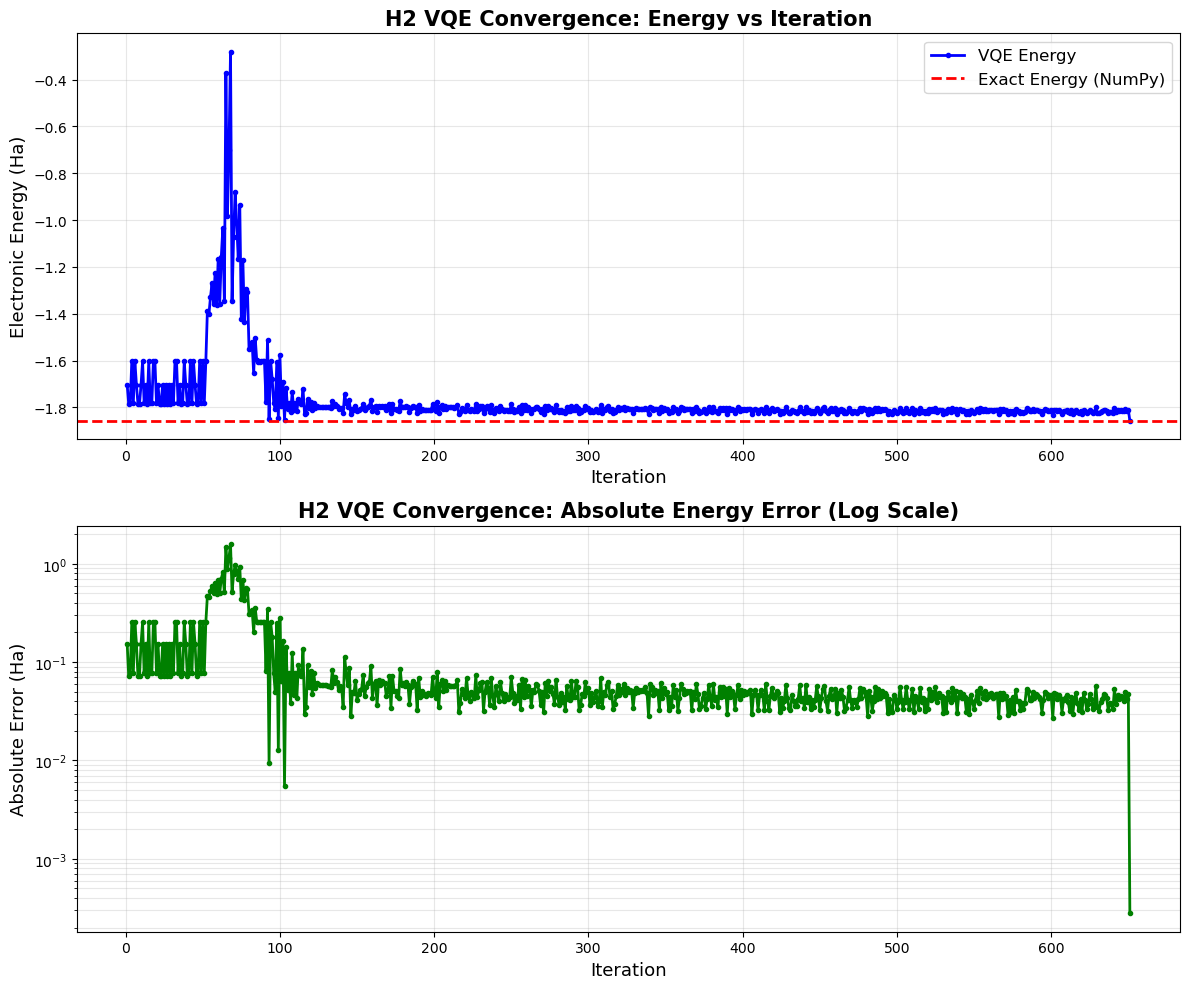


CONVERGENCE STATISTICS FOR LiH
Total iterations:    651
Initial energy:      -1.70294523 Ha
Final energy:        -1.85699566 Ha
Exact energy:        -1.85727503 Ha
Initial error:       1.54e-01 Ha
Final error:         2.79e-04 Ha
Error reduction:     5.52e+02x


In [9]:
# Create convergence plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

iterations = range(1, len(convergence_history) + 1)

# Plot 1: Energy vs Iteration
ax1.plot(iterations, convergence_history, 'b.-', label='VQE Energy', linewidth=2, markersize=6)
ax1.axhline(y=exact_electronic, color='r', linestyle='--', linewidth=2, label='Exact Energy (NumPy)')
ax1.set_xlabel('Iteration', fontsize=13)
ax1.set_ylabel('Electronic Energy (Ha)', fontsize=13)
ax1.set_title('H2 VQE Convergence: Energy vs Iteration', fontsize=15, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Absolute Error vs Iteration (log scale)
absolute_errors = [abs(energy - exact_electronic) for energy in convergence_history]
ax2.semilogy(iterations, absolute_errors, 'g.-', linewidth=2, markersize=6)
ax2.set_xlabel('Iteration', fontsize=13)
ax2.set_ylabel('Absolute Error (Ha)', fontsize=13)
ax2.set_title('H2 VQE Convergence: Absolute Energy Error (Log Scale)', fontsize=15, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Print convergence statistics
print("\n" + "=" * 70)
print("CONVERGENCE STATISTICS FOR LiH")
print("=" * 70)
print(f"Total iterations:    {len(convergence_history)}")
print(f"Initial energy:      {convergence_history[0]:.8f} Ha")
print(f"Final energy:        {convergence_history[-1]:.8f} Ha")
print(f"Exact energy:        {exact_electronic:.8f} Ha")
print(f"Initial error:       {abs(convergence_history[0] - exact_electronic):.2e} Ha")
print(f"Final error:         {abs(convergence_history[-1] - exact_electronic):.2e} Ha")
if abs(convergence_history[-1] - exact_electronic) > 1e-15:
    print(f"Error reduction:     {abs(convergence_history[0] - exact_electronic) / abs(convergence_history[-1] - exact_electronic):.2e}x")
else:
    print(f"Error reduction:     Near machine precision")
print("=" * 70)